In [56]:
from mazeAgentUtils import * 
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setting parameters
Initialising
   making state/history dataframes
   initialising velocity, position and direction
   setting time/run counters
   making the maze walls
   discretising position for later plotting
   handling undefined parameters
   initialising basis features for learning
   calculating state vector at all discretised positions
   initialising STDP weight matrix and traces


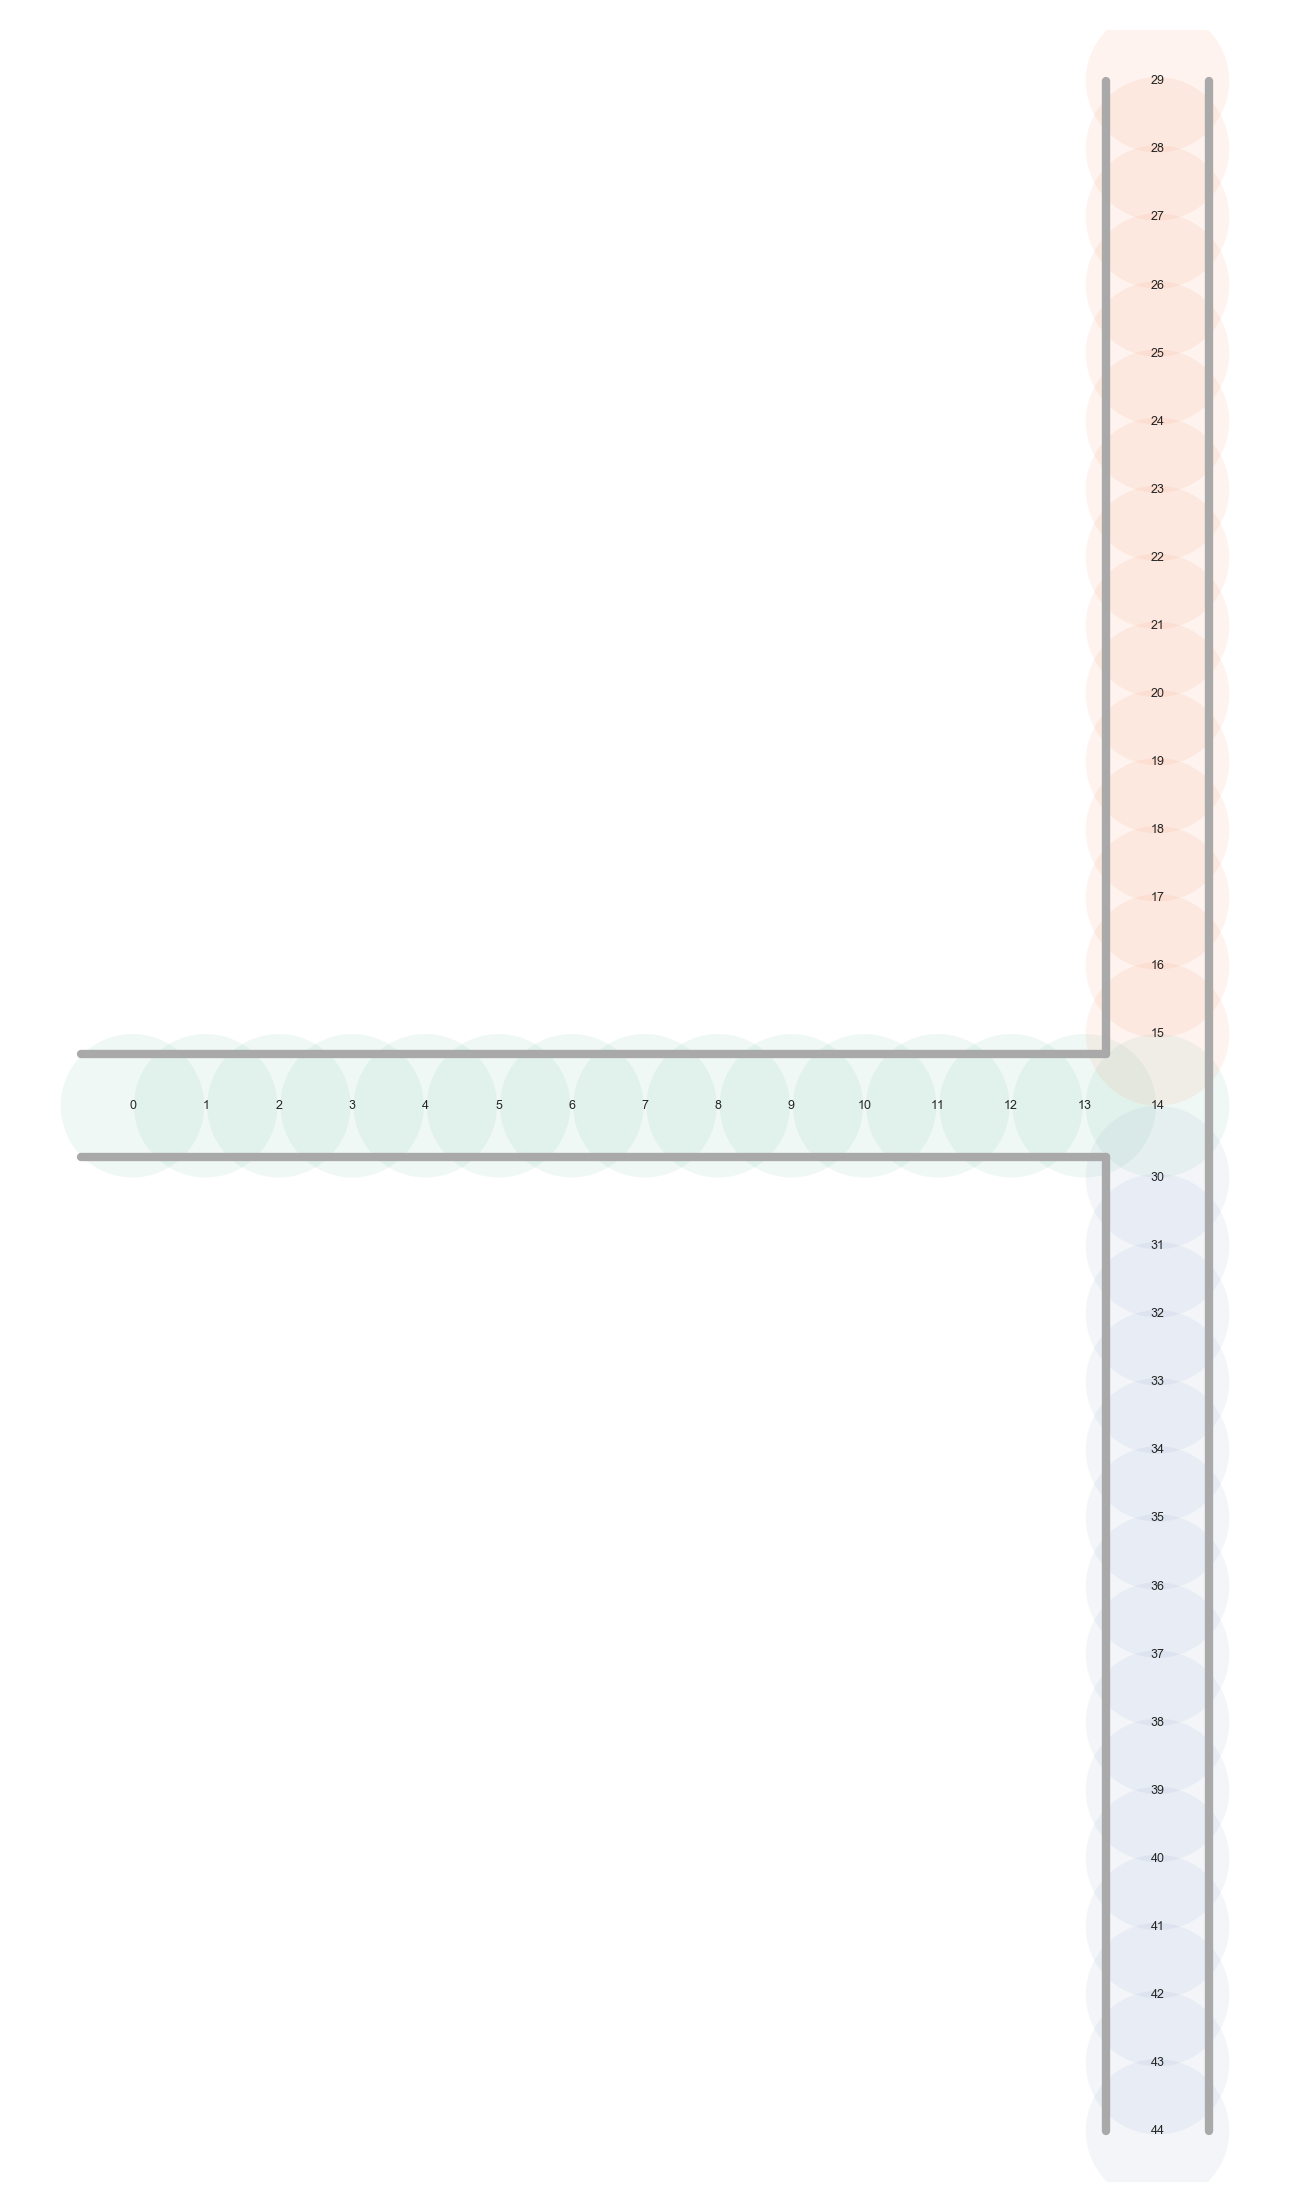

In [57]:
N=15
# xcen = np.linspace(0,3,N)
# ycen = 0.075*np.ones(N)
# centres = np.vstack((xcen,ycen)).T[:-1]

xcen = np.concatenate((np.linspace(0.05,1.05,N),1.05*np.ones(N),1.05*np.ones(N)))
ycen = np.concatenate((np.ones(N),np.linspace(1.07,2,N),np.linspace(0.93,0,N)))
centres = np.vstack((xcen,ycen)).T


params = { 
          'mazeType'           : 'TMaze',               #type of maze, define in getMaze() function
          'stateType'          : 'gaussianThreshold',   #feature on which to TD learn (onehot, gaussian, gaussianCS, fourier, circles)
          'movementPolicy'     : 'windowsScreensaver',  #movement policy (raudies, random walk, windows screensaver)
          'roomSize'           : 1,                     #maze size scaling parameter, metres
          'dt'                 : 0.05,                #simulation time disretisation 
          'dx'                 : 0.01,                  #space discretisation (for plotting, movement is continuous)
          'tau'                : 10,                    #TD decay time, seconds
          'TDdx'               : 0.02,                  #rough distance between TD learning updates, metres 
          'alpha'              : [0.01,0.001],                  #TD learning rate 
          'nCells'             : None,                  #how many features to use
          'centres'            : centres,               #array of receptive field positions. Overwrites nCells
          'speedScale'         : 0.16,                  #movement speed scale, metres/second
          'rotSpeedScale'      : 0.3,                  #rotational speed scale, radians/second
          'initPos'            : None,                  #initial position [x0, y0], metres
          'initDir'            : None,                  #initial direction, unit vector
          'sigma'              : 0.07,                  #feature cell width scale, relevant for  gaussin, gaussianCS, circles
          'placeCellThreshold' : 0.2,                   #place cell threshold value (fraction of its maximum)
          'gridCellThreshold'  : 0,                     #grid cell threshold value (fraction of its maximum)
          'doorsClosed'        : False,                 #whether doors are opened or closed in multicompartment maze
          'cellFiringRate'     : 10,                    #peak firing rate of a cell (middle of place field, preferred theta phase)
          'tau_pre'            : 20e-3,                 #rate potentiating trace decays
          'tau_post'           : 20e-3,                 #rate depressing trace decays 
          'eta_pre'            : 0.01,                  #learning rate for pre to post strengthening 
          'eta_post'           : 0.01,                  #learning rate for post to pre weakening
          'a_pre'              : 1,                     #per trace bump when cell spikes
          'a_post'             : 0.3,                   #post trace bump when cell spikes
          'w_max'              : 20e-3                  #max STDP weights
}

agent =  MazeAgent(params)
agent.toggleDoors(doorsClosed=False)
plotter = Visualiser(agent)
fig, ax = plotter.plotFeatureCells(shufflebeforeplot=False)

In [58]:
agent.pos = np.array([0,1])
agent.dir = np.array([1,0])
agent.runRat(100,STDPLearn=False)

  0%|          | 0/120000 [00:00<?, ?it/s]

Calculating place and grid cells


(<Figure size 1320x2400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff55cd53b70>)

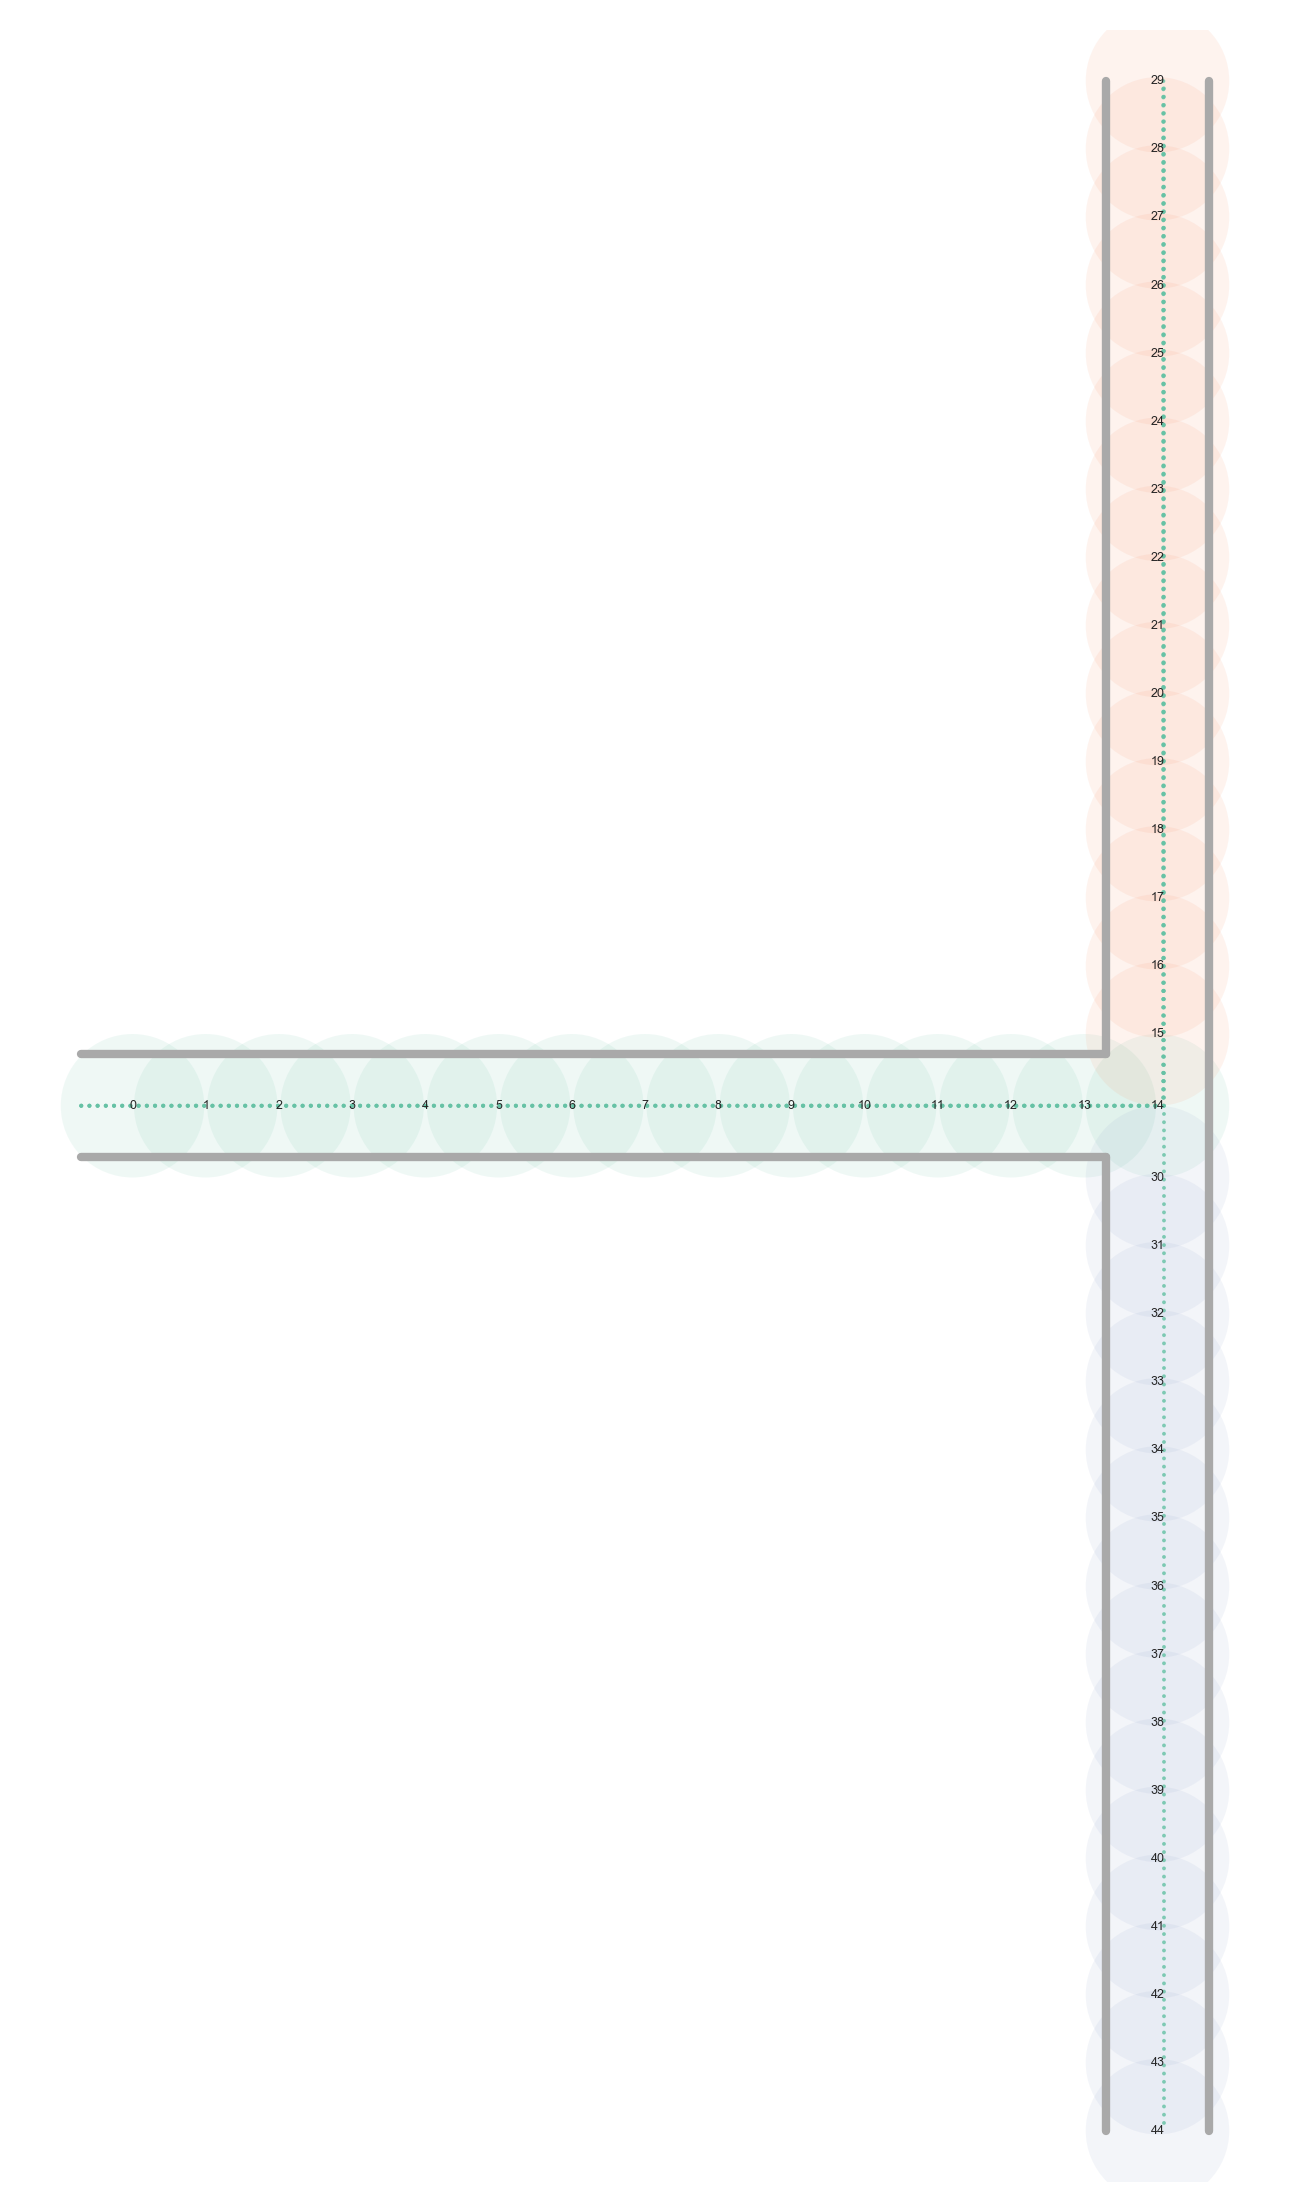

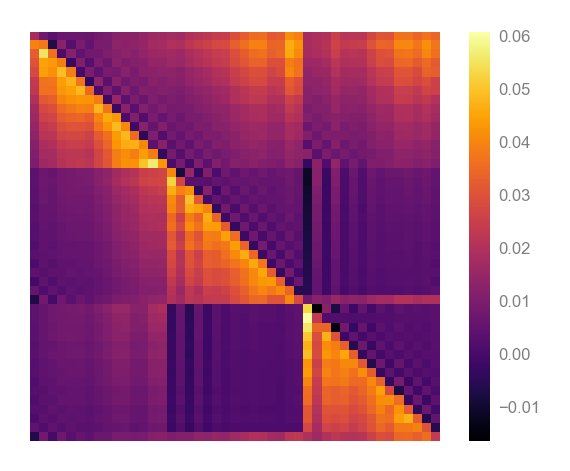

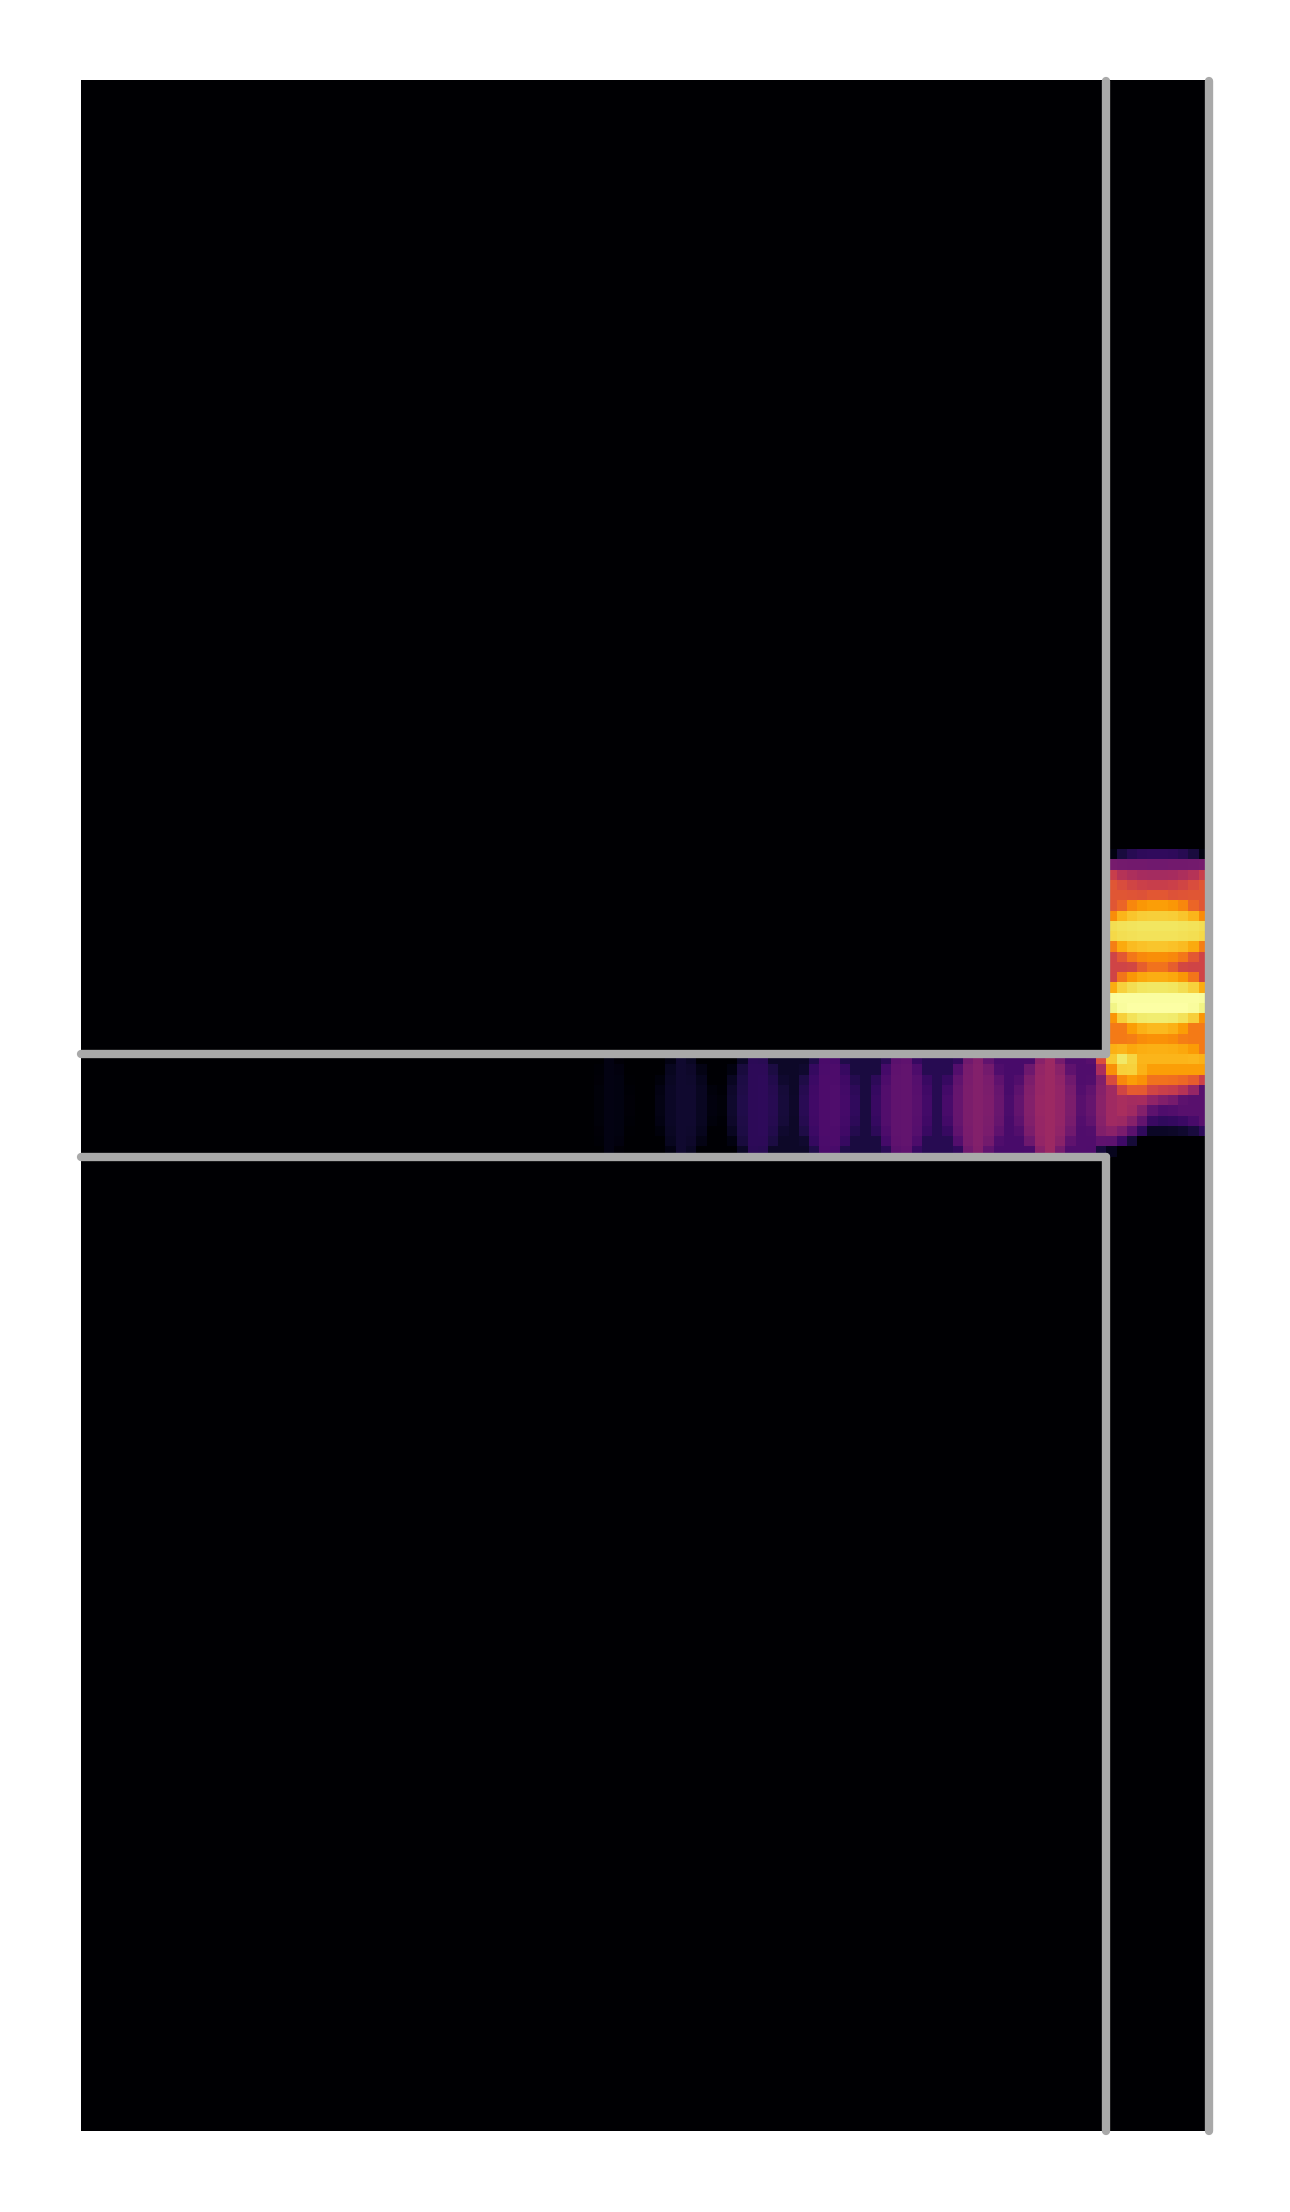

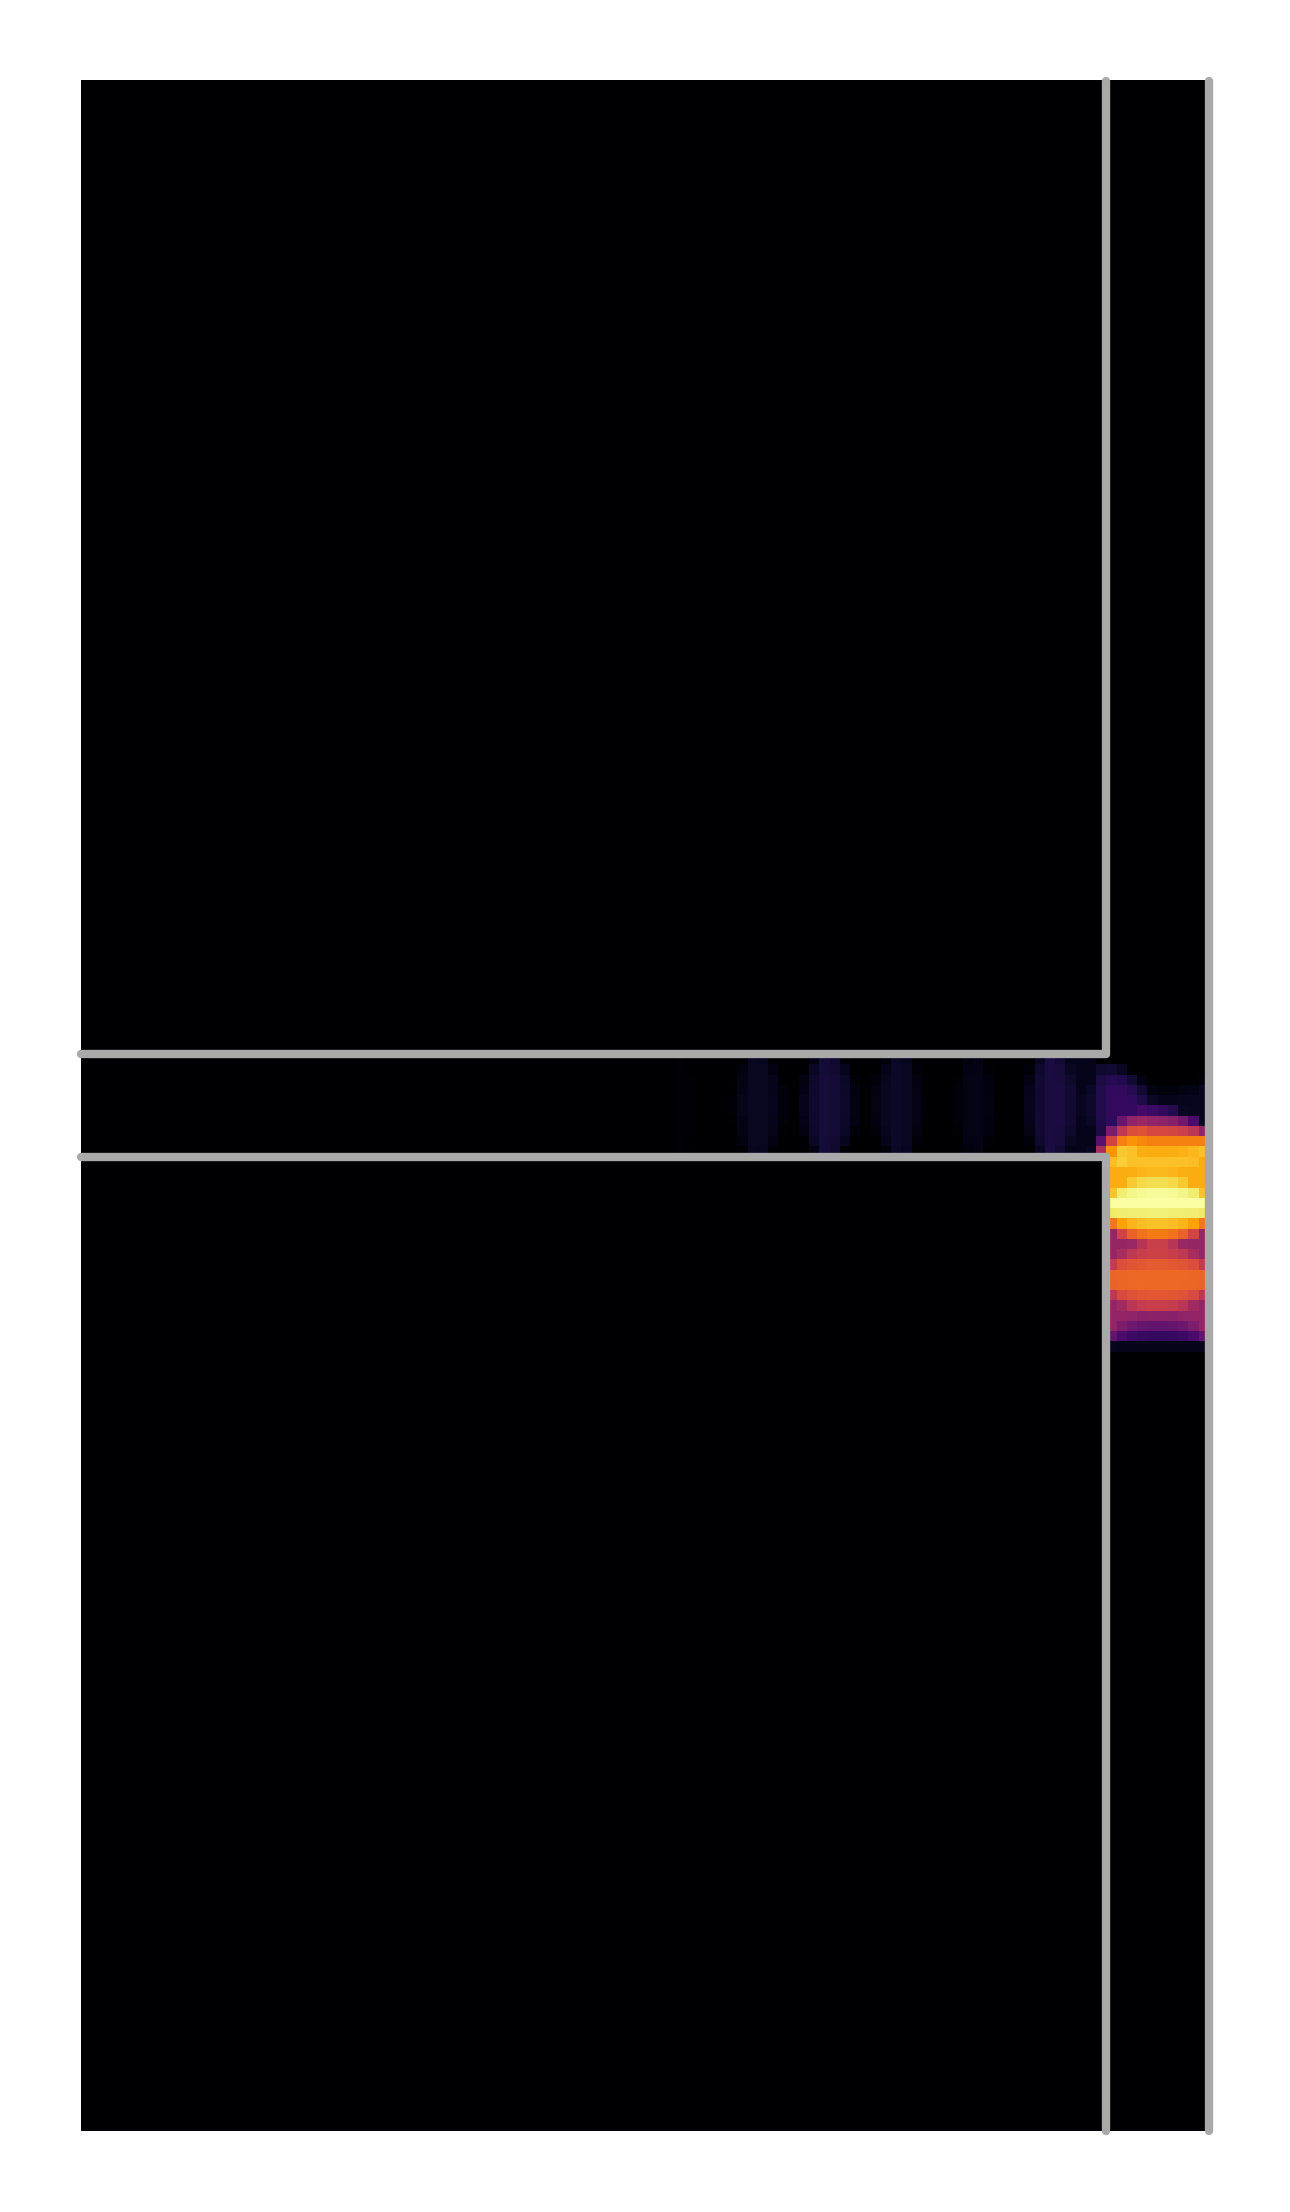

In [59]:
plotter = Visualiser(agent)
fig, ax = plotter.plotFeatureCells(shufflebeforeplot=False)
plottimestart, plottimeend = 0, 1
plotter.plotTrajectory(fig=fig, ax=ax, starttime=(agent.t/60)-1, endtime=agent.t/60, skiprate=1)
# plotter.plotHeatMap()

fig, ax = plotter.plotM()

plotter.plotPlaceField(number=17)
plotter.plotPlaceField(number=32)

# plotter.plotGridField(number=1)

# plotter.plotPlaceField(number=10)

# agent.sigmas



In [24]:
print(np.around(agent.M[:5,:5],3))

[[0.039 0.029 0.026 0.032 0.028]
 [0.044 0.057 0.018 0.046 0.027]
 [0.042 0.061 0.042 0.028 0.036]
 [0.032 0.049 0.046 0.057 0.022]
 [0.028 0.039 0.035 0.054 0.048]]


In [ ]:
x = np.vstack(agent.history['pos'].to_numpy())[:,0]
t = agent.history['t'].to_numpy()
FRs = np.vstack(agent.history['FiringRate'].to_numpy())
print(FRs.shape)
thetaPhase = np.vstack(agent.history['thetaPhase'].to_numpy())

sid, eid = np.argmin(np.abs(t - 0)), np.argmin(np.abs(t - 2))

extent=agent.extent
fig, ax = plt.subplots(1,1,figsize=(2*(extent[1]-extent[0]),6*(extent[3]-extent[2])))

for i in range(FRs.shape[1]):
    ax.scatter(t[sid:eid], FRs[sid:eid,i],s=0.5,alpha=0.5,c='C'+str(i))
ax.plot(t[sid:eid],(0.25*np.sin(thetaPhase/2)**2)[sid:eid],alpha=0.5,color='k',linewidth=0.6)
ax.grid(False)
# ax.set_xlim(extent[0],extent[1])
ax.set_ylim(0,1)
ax.set_xlabel('t / s')
ax.set_ylabel("Firing rate")

saveFigure(fig,"theta",transparent=False)


In [ ]:
a = [np.random.exponential(3) for _ in range(100)]
plt.hist(a)

In [ ]:
FRs = np.vstack(agent.history['FiringRate'].to_numpy())
t = agent.history['t'].to_numpy()
spikeTimes = [[] for i in range(FRs.shape[1])]
for cell in tqdm(range(FRs.shape[1])):
    for timebin in range(FRs.shape[0]-1):
        fr = 20*FRs[timebin,cell] + 0.5
        ts, te = t[timebin], t[timebin+1]
        dt = te - ts
        number_of_spikes = np.random.poisson(fr*dt)
        if number_of_spikes != 0:
            time_of_spikes = np.random.uniform(ts,te,number_of_spikes)
            for spiketime in time_of_spikes:
                spikeTimes[cell].append(spiketime) 
spikecounts = [len(cell) for cell in spikeTimes]
print(spikecounts)
print(f"{sum(spikecounts)} spikes in total")

In [ ]:
import nelpy as nel
import nelpy.plotting as npl
st = nel.SpikeTrainArray(spikeTimes)
ts, te = 0*60, 1*60
# ts, te = 0, 2
# ts, te = 0, 0.25
epoch = nel.EpochArray([ts,te])
axcs, axrs = npl.rastercountplot(st[epoch],nbins=int((te-ts)/0.01))
npl.utils.no_yticklabels(axrs)
npl.utils.no_yticks(axrs)
axrs.set_ylabel('{} units'.format(st.n_units))
axcs.set_title(f"Spike raster plot (first {int(te-ts)} seconds)")
saveFigure(axcs.figure,"raster")

In [ ]:
#params
tau_plus = 20e-3 #time scale at LTP decays 
tau_minus = 20e-3 #time scale at which LTD decays 
a_plus = 1
a_minus = 0.3
eta_plus = 0.01
eta_minus = 0.01
w_max = 1

#convert spikes to list 
spikeIDs = [[i]*len(spikeTimes[i]) for i in range(len(spikeTimes))]
spikeTimeList = np.concatenate(spikeTimes)
spikeIDList = np.concatenate(spikeIDs)
sortIDs = np.argsort(spikeTimeList)
spikeTimeList, spikeIDList = spikeTimeList[sortIDs], spikeIDList[sortIDs]

W = np.identity(agent.nCells)
for _ in range(1):
    #initialise arrays 
    preTrace = np.zeros(agent.nCells)
    postTrace = np.zeros(agent.nCells)
    templist = [] 
    lastTime = -10
    #iterate over spikes
    for i in tqdm(range(len(spikeTimeList))):
        templist.append(preTrace[4])
        time = spikeTimeList[i]
        spikeID = spikeIDList[i] 

        #update traces
        timeDiff = time - lastTime
        preTrace = preTrace * np.exp(- timeDiff / tau_plus)
        postTrace = postTrace * np.exp(- timeDiff / tau_minus)
        preTrace[spikeID] += a_plus
        postTrace[spikeID] += a_minus

        #update weights
        #pre updates 
        weightsToPost = W[:,spikeID]
        A_plus = (w_max - weightsToPost) * eta_plus
        weightsToPost += A_plus * preTrace
        #post updates 
        weightsFromPost = W[spikeID,:]
        A_minus = weightsToPost * eta_minus
        weightsFromPost += -A_minus * postTrace


        lastTime=time


plotter.plotM(M=W.T)



In [ ]:
np.random.choice([(0,1),(1,1)],p=[0.8,0.2])


In [ ]:
agent.pos

In [ ]:
plotter.plotTrajectory(starttime=4.9,endtime=5)